In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'PySR': {'scaling_parameter': 'niterations'},
    'v20.0-60M': {'scaling_parameter': 'choices'},
}

In [4]:
for model in results.keys():
    print(f"Processing model {model}")
    if not 'scaling_parameter' in results[model]:
        raise ValueError("Please specify the scaling parameter for the model.")
    scaling_parameter = results[model]['scaling_parameter']

    # In the directory, there are multiple directories named "evaluation_<scaling_parameter_name>_<scaling_parameter_value>.yaml",
    # each each containing files "<test_set_name>.pickle" with the evaluation results for a specific test set.
    evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}'))

    evaluations_list = [d for d in evaluations_list if d.startswith(f'evaluation_{scaling_parameter}_')]
    scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

    scaling_values_argsort = np.argsort(scaling_values)
    scaling_values = [scaling_values[i] for i in scaling_values_argsort]
    evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

    results[model]['scaling_values'] = scaling_values
    results[model]['evaluations_list'] = evaluations_list
    results[model]['results'] = {}

    print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
    for d in evaluations_list:
        print(f" - {d}")

Processing model PySR
Found 3 evaluations with scaling values: [1, 4, 16]
 - evaluation_niterations_1
 - evaluation_niterations_4
 - evaluation_niterations_16
Processing model v20.0-60M
Found 9 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256]
 - evaluation_choices_1
 - evaluation_choices_2
 - evaluation_choices_4
 - evaluation_choices_8
 - evaluation_choices_16
 - evaluation_choices_32
 - evaluation_choices_64
 - evaluation_choices_128
 - evaluation_choices_256


In [5]:
TEST_SETS_FILTER = ['pool_15_10']

In [6]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for d in tqdm(results[model]['evaluations_list'], desc="Loading evaluation results"):
        for test_set in TEST_SETS_FILTER:
            path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}', d, f"{test_set}.pickle")
            if not os.path.exists(path_to_pickle):
                print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                continue
            with open(path_to_pickle, 'rb') as f:
                result = pickle.load(f)
            niterations = int(d.split('_')[-1].split('.')[0])
            if test_set not in results[model]['results']:
                results[model]['results'][test_set] = {}
            results[model]['results'][test_set][niterations] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 3/3 [00:00<00:00, 10.05it/s]


dict_keys(['pool_15_10'])


Loading evaluation results: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]

dict_keys(['pool_15_10'])


In [9]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'expression': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_constants': [],
    'predicted_expression': [],
    'predicted_expression_encoded': [],
    'predicted_expression_prefix': [],
    'predicted_expression_simplified': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,
}

In [10]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [11]:
results.keys()

dict_keys(['PySR', 'v20.0-60M'])

In [12]:
print(results['v20.0-60M']['results']['pool_15_10'][1].keys())

dict_keys(['constants', 'error', 'expression', 'fit_time', 'input_ids', 'labels', 'labels_decoded', 'n_support', 'parsimony', 'predicted_constants', 'predicted_expression', 'predicted_expression_encoded', 'predicted_expression_prefix', 'predicted_expression_simplified', 'predicted_score', 'prediction_success', 'skeleton', 'skeleton_hash', 'x', 'x_val', 'y', 'y_noisy', 'y_noisy_val', 'y_pred', 'y_pred_val', 'y_val'])


In [13]:
from flash_ansr.eval.token_prediction import f1_score

In [14]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return 0
        return np.inf
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
    scale = 1 / np.mean((y_true - y_pred) ** 2)
    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)
    fvu = safe_divide(ss_res, ss_tot)
    return fvu

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps


for model in results.keys():
    for test_set in results[model]['results'].keys():
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                results[model]['results'][test_set][scaling_value][f'fvu_{split}'] = np.array(
                    [fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                
                results[model]['results'][test_set][scaling_value][f'log10_fvu_{split}'] = np.array(
                    [log10_fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                                
                results[model]['results'][test_set][scaling_value][f'is_perfect_fit_{split}'] = np.array(
                    [is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                
            results[model]['results'][test_set][scaling_value]['f1_score'] = np.array(
                [f1_score(
                    np.array([results[model]['results'][test_set][scaling_value]['predicted_expression_simplified'][i]]),
                    np.array([results[model]['results'][test_set][scaling_value]['expression'][i]])) for i in range(len(results[model]['results'][test_set][scaling_value]['expression']))])
            
            results[model]['results'][test_set][scaling_value]['expression_length'] = np.array(
                [len(expr) if expr is not None else np.nan for expr in results[model]['results'][test_set][scaling_value]['expression']])
            
            results[model]['results'][test_set][scaling_value]['n_variables'] = np.array(
                [len(set(token for token in expr if token.startswith('x'))) if expr is not None else np.nan for expr in results[model]['results'][test_set][scaling_value]['expression']])

print(results['v20.0-60M']['results']['pool_15_10'][1]['fvu_val'][:4])

/tmp/ipykernel_3417/1380035463.py:16: RuntimeWarning: invalid value encountered in multiply
  ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
/tmp/ipykernel_3417/1380035463.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 1 / np.mean((y_true - y_pred) ** 2)
/tmp/ipykernel_3417/1380035463.py:16: RuntimeWarning: invalid value encountered in subtract
  ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_3417/1380035463.py:15: RuntimeWarning: overflow encountered in square
  scale = 1 / np.mean((y_true - y_pred) ** 2)
/tmp/ipykernel_3417/1380035463.py:17: RuntimeWarning: invalid value encountered in subtract
  ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)
/tmp/ipykernel_3417/1380035463.py:

1.2738918 inf
1.2738918 inf
1.2738918 inf
6.9685636 inf
6.9685636 inf
6.9685636 inf
0.5058093 inf
0.5058093 inf
0.5058093 inf
[1.41977804e-01 3.89373268e-01 2.14863086e+00 4.65978337e-05]


In [15]:
results['v20.0-60M']['results']['pool_15_10'][1]['fvu_val'].shape, results['v20.0-60M']['results']['pool_15_10'][1]['fit_time'].shape

((4096,), (4096,))

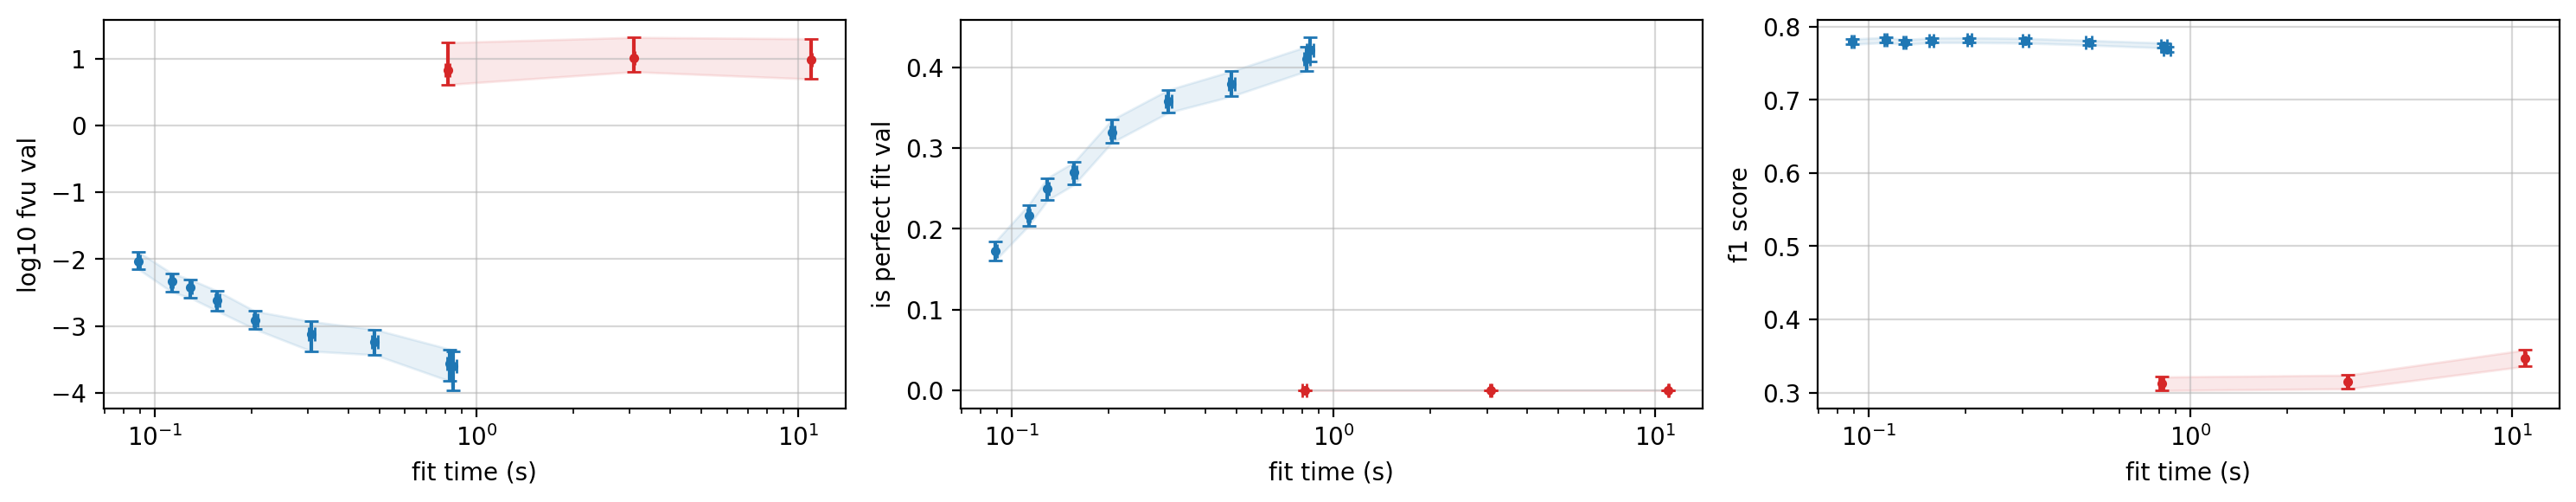

In [20]:
metric_pairs = [
    (('fit_time', np.nanmedian), ('log10_fvu_val', np.nanmedian)),
    (('fit_time', np.nanmedian), ('is_perfect_fit_val', np.nanmean)),
    (('fit_time', np.nanmedian), ('f1_score', np.nanmean)),
]

models = [
    ('PySR', 'niterations', 'tab:red'),
    ('v20.0-60M', 'choices', 'tab:blue'),
]

COLS = 3
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200)

for ax, ((x_metric, x_statistic), (y_metric, y_statistic)) in zip(axes.flatten(), metric_pairs):
    for model_name, scaling_param, color in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        for n in results[model_name]['results']['pool_15_10'].keys():
            x = results[model_name]['results']['pool_15_10'][n][x_metric]
            y = results[model_name]['results']['pool_15_10'][n][y_metric]

            y[y == -np.inf] = np.log10(np.finfo(np.float32).eps)  # Replace -inf with a very small number for bootstrapping

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1000, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1000, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median), np.array(y_lower), np.array(y_upper)

        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label='PySR', capsize=3, color=color)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

    ax.set_xlabel('fit time (s)')
    ax.set_ylabel(y_metric.replace('_', ' '))
    ax.set_xscale('log')
    ax.set_yscale('linear')

    ax.grid(alpha=0.5)

for ax in axes.flatten()[len(metric_pairs):]:
    ax.axis('off')

fig.tight_layout()

In [17]:
n

256

Text(0, 0.5, 'log10_fvu_val')

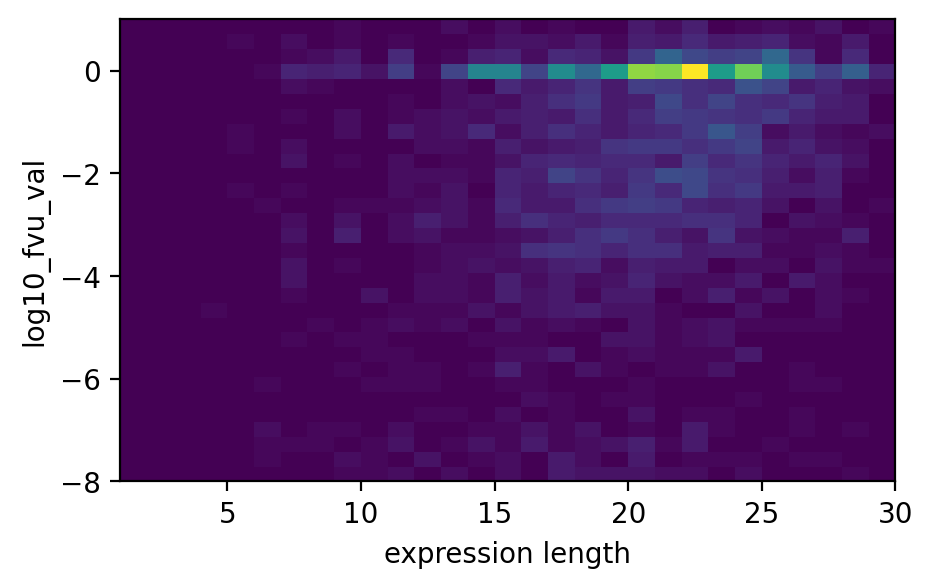

In [18]:
x = results[model_name]['results']['pool_15_10'][n]['expression_length']
y = results[model_name]['results']['pool_15_10'][n]['log10_fvu_val']

x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median), np.array(y_lower), np.array(y_upper)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

ax.hist2d(x, y, bins=(np.unique(x[np.isfinite(x)]), np.linspace(-8, 1, 32)));
ax.set_xlabel('expression length')
ax.set_ylabel('log10_fvu_val')


Text(0, 0.5, 'log10_fvu_val')

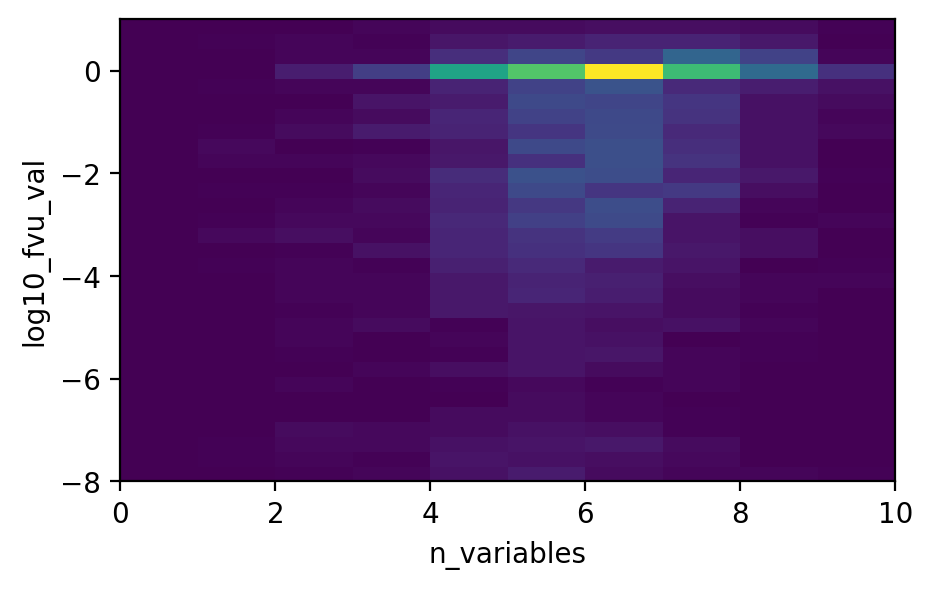

In [19]:
x = results[model_name]['results']['pool_15_10'][n]['n_variables']
y = results[model_name]['results']['pool_15_10'][n]['log10_fvu_val']

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

ax.hist2d(x, y, bins=(np.unique(x[np.isfinite(x)]), np.linspace(-8, 1, 32)));
ax.set_xlabel('n_variables')
ax.set_ylabel('log10_fvu_val')